# Fashion Product Classification

**Deep Learning Phase 1**

---

## 1. Introduction

This notebook demonstrates a complete workflow for classification of fashion product images, including:

Data Preparation:	Combines the Kaggle Fashion Product Images dataset with your custom uploaded images and cleans missing files.

Data Augmentation:	Applies spatial (rotation, perspective) and photometric (color jitter, sharpness) transformations.

Model Construction:	Uses ResNet-50 (ImageNet pretrained) as backbone, replacing the FC layer for your 15 fashion classes.

Fine-Tuning Schedule:	Progressive unfreezing across 4 stages, each with its own learning rate.

Evaluation Metrics:	Tracks training/validation accuracy, confusion matrix, and Grad-CAM heatmaps for interpretability.

GUI Deployment:	Integrates the trained model into a Tkinter application for end-user testing and visualization.
---


In [2]:
# ======================================
# 1. Introduction & Imports
# ======================================

# --- Core libraries ---
import os
import glob
import pickle
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- PyTorch ---
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
    import torchvision.transforms as transforms
    import torchvision.models as models
    from torch.cuda.amp import autocast, GradScaler

except Exception as e:
    raise RuntimeError("PyTorch did not import correctly. "
                       "Check if a file named `torch.py` exists in your folder and remove it.") from e

from tqdm import tqdm


# --- Safety: suppress warnings ---
warnings.filterwarnings("ignore")

# --- Sanity check: confirm correct PyTorch is loaded ---
print("Torch version:", torch.__version__)
print("Torch file:", torch.__file__)
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.5.1+cu121
Torch file: C:\Users\rando\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\__init__.py
CUDA available: True


## 2. Data Loading

**Assumption:** Dataset is extracted to `fashion-product-images/` in the workspace root.

- Images: `fashion-product-images/images/`
- Metadata: `fashion-product-images/styles.csv`

In [3]:
# ============================================================================
# LOCAL DATASET PATHS
# ============================================================================

# Your local dataset directory
LOCAL_DIR = r"d:/AAI3001/fashion-dataset/fashion-dataset"
LOCAL_IMG_DIR = os.path.join(LOCAL_DIR, "images")
CSV_PATH = os.path.join(LOCAL_DIR, "styles.csv")

print(f"✅ Using local dataset from: {LOCAL_DIR}")
print(f"📁 Images directory: {LOCAL_IMG_DIR}")
print(f"📄 CSV path: {CSV_PATH}")

# --- Verify paths exist ---
if not os.path.exists(LOCAL_DIR):
    raise FileNotFoundError(f"❌ Dataset directory not found: {LOCAL_DIR}")
if not os.path.exists(LOCAL_IMG_DIR):
    raise FileNotFoundError(f"❌ Images directory not found: {LOCAL_IMG_DIR}")
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"❌ CSV file not found: {CSV_PATH}")

# --- Load metadata ---
import pandas as pd
styles = pd.read_csv(CSV_PATH, on_bad_lines="skip")
print(f"✅ Loaded CSV with {len(styles)} entries")

# --- Build image path function (local only, includes your 55 custom images) ---
def get_image_path(img_id):
    # Try multiple file extensions (handles .jpg, .JPG, .JPEG, .jpeg)
    for ext in ['.jpg', '.JPG', '.JPEG', '.jpeg']:
        local_path = os.path.join(LOCAL_IMG_DIR, f"{img_id}{ext}")
        if os.path.exists(local_path):
            return local_path
    return None  # handle missing later

styles["image_path"] = styles["id"].apply(get_image_path)

# --- 6️⃣ Drop missing image files safely ---
styles["exists"] = styles["image_path"].apply(lambda p: os.path.exists(p) if p else False)
missing = styles[~styles["exists"]]

if len(missing) > 0:
    print(f"⚠️ {len(missing)} images listed in CSV but missing in folder(s). They will be skipped.")
    print("Example missing IDs:", missing["id"].head(5).tolist())

styles = styles[styles["exists"]].reset_index(drop=True)
styles = styles.drop(columns=["exists"], errors="ignore")

# --- 7️⃣ Final sanity check ---
print(f"✅ Final dataset contains {len(styles)} valid image paths.")
print("Example entries:")
print(styles[["id", "articleType", "image_path"]].head())

✅ Using local dataset from: d:/AAI3001/fashion-dataset/fashion-dataset
📁 Images directory: d:/AAI3001/fashion-dataset/fashion-dataset\images
📄 CSV path: d:/AAI3001/fashion-dataset/fashion-dataset\styles.csv
✅ Loaded CSV with 44479 entries
⚠️ 5 images listed in CSV but missing in folder(s). They will be skipped.
Example missing IDs: [39403, 39410, 39401, 39425, 12347]
✅ Final dataset contains 44474 valid image paths.
Example entries:
      id  articleType                                         image_path
0  15970       Shirts  d:/AAI3001/fashion-dataset/fashion-dataset\ima...
1  39386        Jeans  d:/AAI3001/fashion-dataset/fashion-dataset\ima...
2  59263      Watches  d:/AAI3001/fashion-dataset/fashion-dataset\ima...
3  21379  Track Pants  d:/AAI3001/fashion-dataset/fashion-dataset\ima...
4  53759      Tshirts  d:/AAI3001/fashion-dataset/fashion-dataset\ima...
⚠️ 5 images listed in CSV but missing in folder(s). They will be skipped.
Example missing IDs: [39403, 39410, 39401, 39425, 1

## 3. Exploratory Data Analysis (EDA)

Let's explore the dataset: missing values, label distributions, and sample images.

In [4]:
print("===== BASIC INFO =====")
styles.info()

print("\n===== DESCRIPTIVE STATISTICS =====")
display(styles.describe(include='all'))

print("\n===== SAMPLE ROWS =====")
display(styles.head(5))

# --- Unique classes ---
if "articleType" in styles.columns:
    print("\n===== CLASS DISTRIBUTION =====")
    class_counts = styles["articleType"].value_counts()
    print(class_counts)

    plt.figure(figsize=(10,6))


===== BASIC INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44474 entries, 0 to 44473
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44474 non-null  int64  
 1   gender              44474 non-null  object 
 2   masterCategory      44474 non-null  object 
 3   subCategory         44474 non-null  object 
 4   articleType         44474 non-null  object 
 5   baseColour          44459 non-null  object 
 6   season              44453 non-null  object 
 7   year                44473 non-null  float64
 8   usage               44157 non-null  object 
 9   productDisplayName  44467 non-null  object 
 10  image_path          44474 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.7+ MB

===== DESCRIPTIVE STATISTICS =====


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
count,44474.000000,44474,44474,44474,44474,44459,44453,44473.000000,44157,44467,44474
unique,NaN,5,7,45,144,50,5,NaN,9,31170,44474
top,NaN,Men,Apparel,Topwear,Tshirts,Black,Summer,NaN,Casual,Lucera Women Silver Earrings,d:/AAI3001/fashion-dataset/fashion-dataset\ima...
freq,NaN,22167,21445,15430,7070,9734,21470,NaN,34442,82,1
mean,29733.361267,NaN,NaN,NaN,NaN,NaN,NaN,2012.818811,NaN,NaN,NaN
std,17072.769911,NaN,NaN,NaN,NaN,NaN,NaN,2.156434,NaN,NaN,NaN
min,1163.000000,NaN,NaN,NaN,NaN,NaN,NaN,2007.000000,NaN,NaN,NaN
25%,14782.250000,NaN,NaN,NaN,NaN,NaN,NaN,2011.000000,NaN,NaN,NaN
50%,28645.500000,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,NaN,NaN,NaN
75%,44729.750000,NaN,NaN,NaN,NaN,NaN,NaN,2015.000000,NaN,NaN,NaN



===== SAMPLE ROWS =====


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,d:/AAI3001/fashion-dataset/fashion-dataset\ima...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,d:/AAI3001/fashion-dataset/fashion-dataset\ima...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,d:/AAI3001/fashion-dataset/fashion-dataset\ima...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,d:/AAI3001/fashion-dataset/fashion-dataset\ima...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,d:/AAI3001/fashion-dataset/fashion-dataset\ima...



===== CLASS DISTRIBUTION =====
articleType
Tshirts                7070
Shirts                 3228
Casual Shoes           2846
Watches                2542
Sports Shoes           2036
                       ... 
Mens Grooming Kit         1
Body Wash and Scrub       1
Ipad                      1
Denim Jacket              1
Puffer Jacket             1
Name: count, Length: 144, dtype: int64


<Figure size 1000x600 with 0 Axes>


===== LONG-TAIL DISTRIBUTION =====


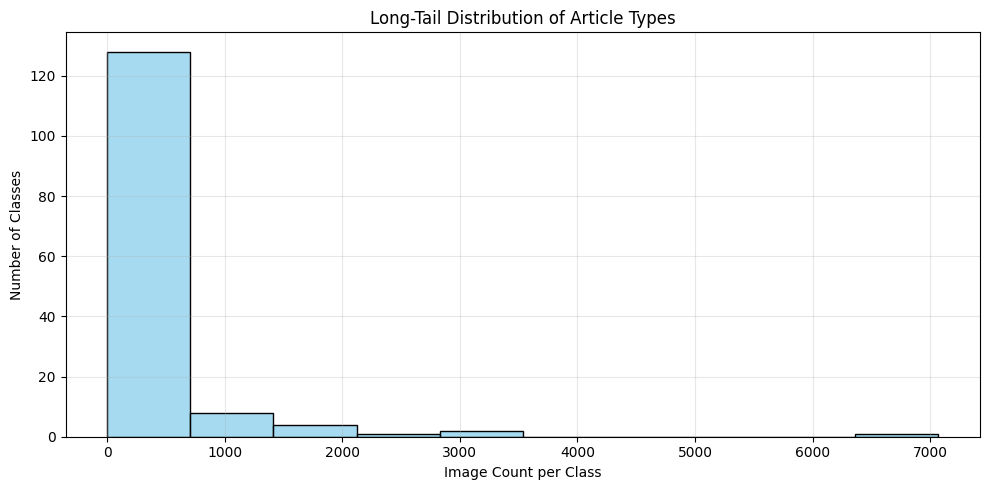

In [5]:
# --- Long-tail distribution insight ---
print("\n===== LONG-TAIL DISTRIBUTION =====")
plt.figure(figsize=(10,5))
sns.histplot(class_counts.values, bins=10, kde=False, color="skyblue")
plt.title("Long-Tail Distribution of Article Types")
plt.xlabel("Image Count per Class")
plt.ylabel("Number of Classes")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

- Drop classes down to only topwear and bottomwear which is what we are focusing on.
- Encode categorical labels
- Prepare train/val/test splits

In [6]:
# --- Allowed articleTypes (updated with Blazers + Waistcoat) ---
ALLOWED_TOP = [
    "Tshirts", "Shirts", "Tops", "Sweatshirts", "Jackets", "Sweaters",
    "Blazers", "Waistcoat"
]
ALLOWED_BOTTOM = [
    "Jeans", "Trousers", "Shorts", "Skirts", "Track Pants", "Leggings", "Swimwear"
]
ALLOWED = set(ALLOWED_TOP + ALLOWED_BOTTOM)

# --- 1️⃣ Filter valid rows ---
styles = styles.dropna(subset=["id","articleType"]).copy()
styles["id"] = styles["id"].astype(int)

# Keep only Topwear + Bottomwear classes
styles = styles[styles["articleType"].isin(ALLOWED)].copy()

# --- 2️⃣ Filter by image existence (already validated earlier) ---
styles = styles[styles["image_path"].apply(os.path.exists)].reset_index(drop=True)
print(f"✅ {len(styles)} images retained after filtering allowed classes and valid paths.")

# --- 3️⃣ Encode labels ---
le_product_type = LabelEncoder()
styles["product_type_label"] = le_product_type.fit_transform(styles["articleType"])

# Save encoder for GUI inference (local path)
with open(r"d:/AAI3001/le_product_type_extended.pkl", "wb") as f:
    pickle.dump(le_product_type, f)

LABELS = le_product_type.classes_.tolist()
NUM_CLASSES = len(LABELS)

print(f"✅ {NUM_CLASSES} classes → {LABELS}")

✅ 15241 images retained after filtering allowed classes and valid paths.
✅ 15 classes → ['Blazers', 'Jackets', 'Jeans', 'Leggings', 'Shirts', 'Shorts', 'Skirts', 'Sweaters', 'Sweatshirts', 'Swimwear', 'Tops', 'Track Pants', 'Trousers', 'Tshirts', 'Waistcoat']



===== CLASS BALANCE SUMMARY =====
Tshirts        :   7070 images (46.39%)
Shirts         :   3228 images (21.18%)
Tops           :   1764 images (11.57%)
Jeans          :    610 images ( 4.00%)
Shorts         :    548 images ( 3.60%)
Trousers       :    533 images ( 3.50%)
Track Pants    :    306 images ( 2.01%)
Sweatshirts    :    289 images ( 1.90%)
Sweaters       :    278 images ( 1.82%)
Jackets        :    261 images ( 1.71%)
Leggings       :    177 images ( 1.16%)
Skirts         :    132 images ( 0.87%)
Waistcoat      :     17 images ( 0.11%)
Swimwear       :     17 images ( 0.11%)
Blazers        :     11 images ( 0.07%)


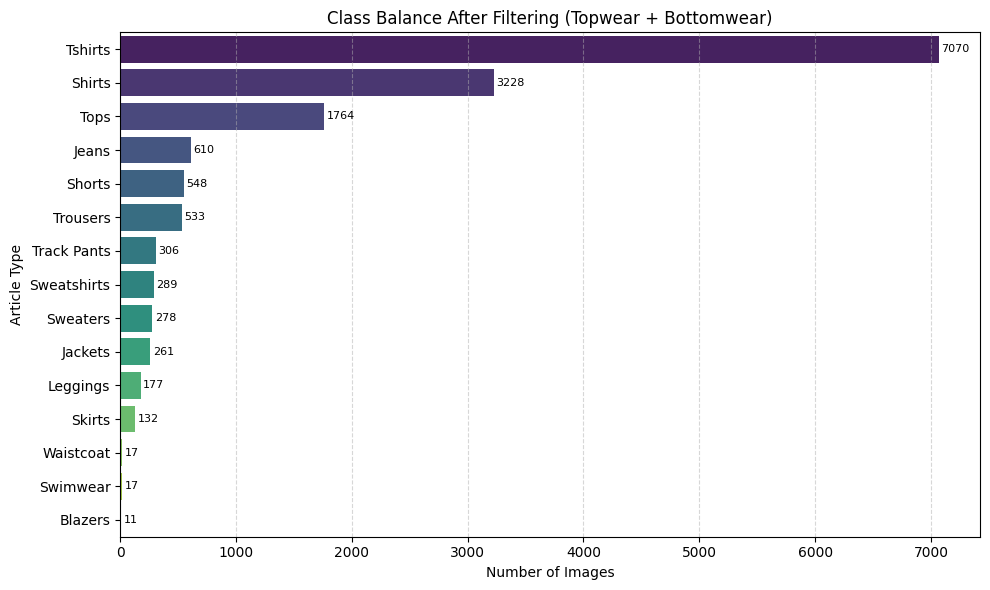

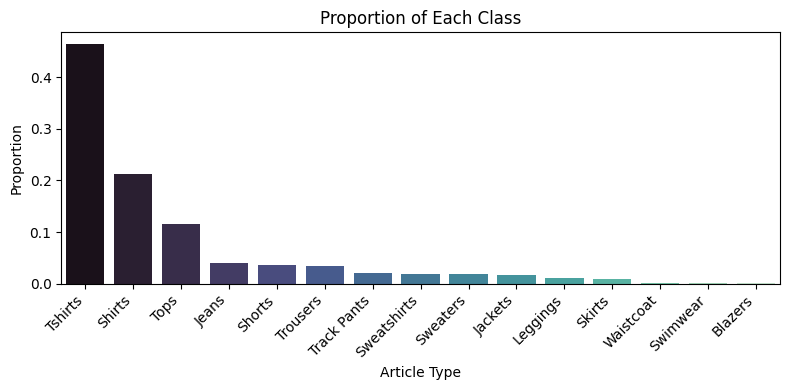

In [7]:
# Count images per class
class_counts = styles["articleType"].value_counts().sort_values(ascending=False)
total_images = class_counts.sum()

print("\n===== CLASS BALANCE SUMMARY =====")
for cls, count in class_counts.items():
    pct = (count / total_images) * 100
    print(f"{cls:<15}: {count:>6} images ({pct:5.2f}%)")

# --- Plot the distribution ---
plt.figure(figsize=(10,6))
sns.barplot(y=class_counts.index, x=class_counts.values, palette="viridis")

plt.title("Class Balance After Filtering (Topwear + Bottomwear)")
plt.xlabel("Number of Images")
plt.ylabel("Article Type")

# Annotate counts on bars
for i, (count, cls) in enumerate(zip(class_counts.values, class_counts.index)):
    plt.text(count + 20, i, f"{count}", va="center", fontsize=8)

plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- Optional: visualize as proportions ---
plt.figure(figsize=(8,4))
sns.barplot(x=class_counts.index, y=class_counts.values / total_images, palette="mako")
plt.xticks(rotation=45, ha="right")
plt.title("Proportion of Each Class")
plt.ylabel("Proportion")
plt.xlabel("Article Type")
plt.tight_layout()
plt.show()


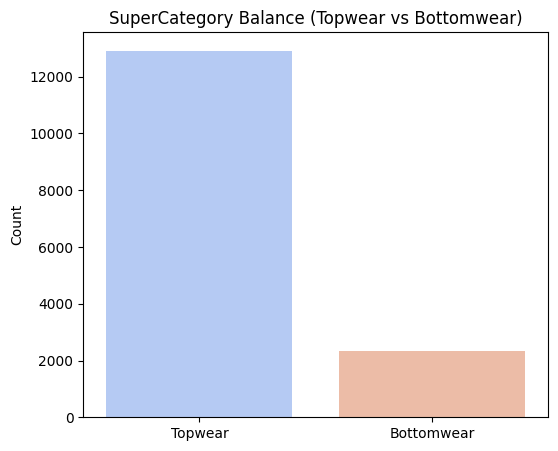

In [7]:
styles["superCategory"] = styles["articleType"].apply(
    lambda x: "Topwear" if x in ALLOWED_TOP else "Bottomwear"
)

plt.figure(figsize=(6,5))
sns.countplot(x="superCategory", data=styles, palette="coolwarm")
plt.title("SuperCategory Balance (Topwear vs Bottomwear)")
plt.xlabel("")
plt.ylabel("Count")
plt.show()

In [8]:
# ===================== RECOMMENDED WEIGHTS FOR SAMPLER =====================

# Compute weights inversely proportional to class frequency
class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float)
class_weights = class_weights / class_weights.sum()  # normalize for readability

# Map each label to its weight
label2weight = {label: class_weights[i].item() for i, label in enumerate(class_counts.index)}
print("\n===== RECOMMENDED CLASS WEIGHTS =====")
for label, weight in label2weight.items():
    print(f"{label:<15}: {weight:.6f}")

# Create a weight array for each sample in the dataset (for WeightedRandomSampler)
label_map = {cls: idx for idx, cls in enumerate(class_counts.index)}
sample_weights = styles["articleType"].map(lambda x: label2weight[x]).values

# Safe Torch tensor
sample_weights_tensor = torch.DoubleTensor(sample_weights)
print(f"\n✅ Sample weights prepared for WeightedRandomSampler (length = {len(sample_weights_tensor)})")


===== RECOMMENDED CLASS WEIGHTS =====
Tshirts        : 0.000584
Shirts         : 0.001279
Tops           : 0.002340
Jeans          : 0.006766
Shorts         : 0.007531
Trousers       : 0.007743
Track Pants    : 0.013487
Sweatshirts    : 0.014281
Sweaters       : 0.014846
Jackets        : 0.015813
Leggings       : 0.023317
Skirts         : 0.031266
Waistcoat      : 0.242775
Swimwear       : 0.242775
Blazers        : 0.375197

✅ Sample weights prepared for WeightedRandomSampler (length = 15241)


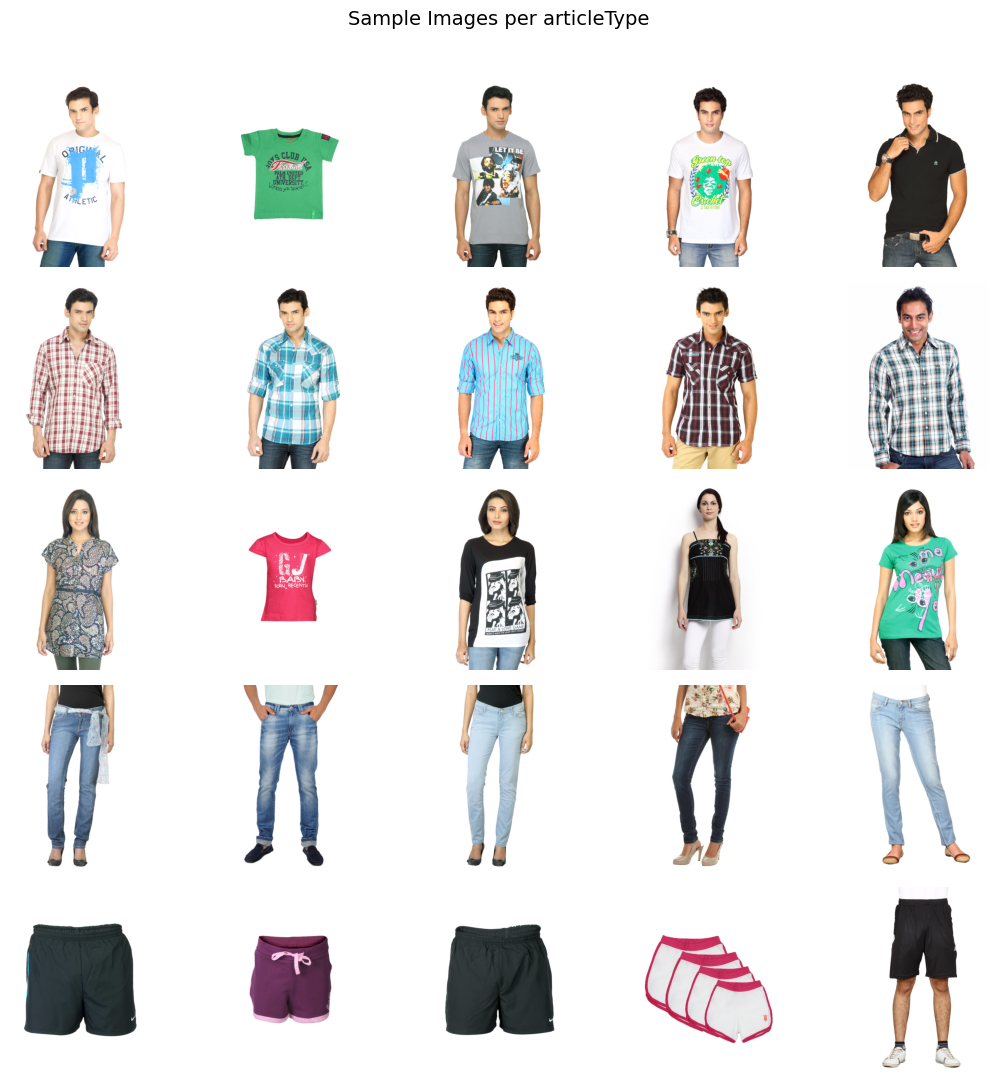

In [9]:
def show_samples(df, col="articleType", n_classes=6, n_per_class=5):
    """Show sample images per class with row labels."""
    classes = df[col].value_counts().index[:n_classes]
    n_classes = len(classes)

    fig, axes = plt.subplots(n_classes, n_per_class, figsize=(n_per_class*2.2, n_classes*2.2))
    if n_classes == 1:
        axes = np.expand_dims(axes, 0)  # ensure iterable for single class

    for i, c in enumerate(classes):
        subset = df[df[col] == c]
        n_show = min(n_per_class, len(subset))
        samples = subset.sample(n_show, random_state=42)

        for j in range(n_per_class):
            ax = axes[i, j] if n_classes > 1 else axes[j]
            ax.axis("off")

            if j < len(samples):
                row = samples.iloc[j]
                img_path = row.get("image_path", None)
                if img_path and os.path.exists(img_path):
                    try:
                        img = Image.open(img_path).convert("RGB")
                        ax.imshow(img)
                    except:
                        ax.imshow(np.zeros((10,10,3)))  # fallback blank
                else:
                    ax.imshow(np.zeros((10,10,3)))  # missing placeholder
            else:
                ax.imshow(np.zeros((10,10,3)))  # pad with blanks

        # 🔹 Label on the left side of each row
        axes[i, 0].set_ylabel(c, fontsize=10, rotation=0, ha="right", va="center")

    plt.suptitle(f"Sample Images per {col}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# --- Preview after filtering ---
show_samples(
    styles,
    col="articleType",
    n_classes=min(5, styles["articleType"].nunique()),
    n_per_class=5
)


In [10]:
# Identify custom images (IDs 60001-60055)
custom_ids = set(range(60001, 60056))
styles["is_custom"] = styles["id"].isin(custom_ids)

# Separate custom images from regular dataset
custom_df = styles[styles["is_custom"]].copy()
regular_df = styles[~styles["is_custom"]].copy()

print(f"📌 Found {len(custom_df)} custom UNIQLO images (IDs 60001-60055)")
print(f"📦 Regular dataset: {len(regular_df)} images")

# --- Split ONLY the regular dataset using stratified sampling ---
train_df_regular, test_df = train_test_split(
    regular_df, test_size=0.10, stratify=regular_df["product_type_label"], random_state=42
)
train_df_regular, val_df = train_test_split(
    train_df_regular, test_size=0.10, stratify=train_df_regular["product_type_label"], random_state=42
)

# --- Add ALL 55 custom images to training set (100% for training) ---
train_df = pd.concat([train_df_regular, custom_df], ignore_index=True)

# Shuffle training set to mix custom + regular images
train_df = train_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("\n✅ Final split:")
print(f"Train: {train_df.shape} (includes ALL {len(custom_df)} custom images)")
print(f"Val:   {val_df.shape} (no custom images)")
print(f"Test:  {test_df.shape} (no custom images)")

# Verify custom images are in training
custom_in_train = train_df["is_custom"].sum()
custom_in_val = val_df["is_custom"].sum() if "is_custom" in val_df.columns else 0
custom_in_test = test_df["is_custom"].sum() if "is_custom" in test_df.columns else 0
print(f"\n🎯 Custom image distribution:")
print(f"   Train: {custom_in_train}/{len(custom_df)} custom images ✅")
print(f"   Val:   {custom_in_val}/{len(custom_df)} custom images")
print(f"   Test:  {custom_in_test}/{len(custom_df)} custom images")

# Optional sanity check
def show_counts(name, subdf):
    cc = subdf["product_type_label"].value_counts().sort_index()
    print(f"\n{name} counts:")
    print(cc.rename(index=dict(enumerate(LABELS))))

show_counts("TRAIN", train_df)
show_counts("VAL", val_df)
show_counts("TEST", test_df)


📌 Found 44 custom UNIQLO images (IDs 60001-60055)
📦 Regular dataset: 15197 images

✅ Final split:
Train: (12353, 13) (includes ALL 44 custom images)
Val:   (1368, 13) (no custom images)
Test:  (1520, 13) (no custom images)

🎯 Custom image distribution:
   Train: 44/44 custom images ✅
   Val:   0/44 custom images
   Test:  0/44 custom images

TRAIN counts:
product_type_label
Blazers           9
Jackets         212
Jeans           494
Leggings        143
Shirts         2618
Shorts          444
Skirts          107
Sweaters        225
Sweatshirts     235
Swimwear         14
Tops           1429
Track Pants     249
Trousers        432
Tshirts        5727
Waistcoat        15
Name: count, dtype: int64

VAL counts:
product_type_label
Blazers          1
Jackets         23
Jeans           55
Leggings        16
Shirts         289
Shorts          49
Skirts          12
Sweaters        25
Sweatshirts     26
Swimwear         1
Tops           159
Track Pants     27
Trousers        48
Tshirts        636

## 5. Model Architecture

Multi-output CNN using a pretrained backbone (ResNet50).

In [11]:
import torchvision.transforms as T

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# ✅ Training augmentations
_pre_tfms_train = T.Compose([
    # --- Spatial variation ---
    T.RandomResizedCrop(224, scale=(0.4, 1.0), ratio=(0.75, 1.33)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.RandomRotation(25)], p=0.3),
    T.RandomAffine(degrees=20, translate=(0.15, 0.15), scale=(0.85, 1.15)),

    # --- Photometric variation ---
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    T.RandomApply([T.RandomAdjustSharpness(2)], p=0.4),
    T.RandomApply([T.RandomAutocontrast(p=0.5)], p=0.3),
    T.RandomApply([T.RandomEqualize(p=0.5)], p=0.3),
    T.RandomApply([T.RandomPosterize(bits=3)], p=0.2),

    # --- Blur and perspective noise ---
    T.RandomPerspective(distortion_scale=0.4, p=0.3),
    T.RandomApply([T.GaussianBlur(kernel_size=3, sigma=(0.3, 2.0))], p=0.3),

    # --- Tensor + normalization ---
    T.ToTensor(),
    T.Normalize(mean, std),

    # --- Regularization ---
    T.RandomErasing(p=0.4, scale=(0.02, 0.25), ratio=(0.3, 3.3)),
])

# ✅ Validation / Test transforms (no augmentation)
_pre_tfms_val = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean, std)
])

print("Train transform defined:", "_pre_tfms_train" in globals())
print("Val transform defined:", "_pre_tfms_val" in globals())

class ProductTypeDataset(Dataset):
    def __init__(self, df, is_train=True):
        self.df = df.reset_index(drop=True)
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            img = Image.open(row["image_path"]).convert("RGB")
        except Exception:
            img = Image.new("RGB", (224, 224), (0, 0, 0))  # fallback if file missing

        # ✅ Apply transforms
        if self.is_train:
            img = _pre_tfms_train(img)
        else:
            img = _pre_tfms_val(img)

        label = int(row["product_type_label"])
        return img, label


Train transform defined: True
Val transform defined: True


In [12]:
# Directory for your custom dataset (local path - includes your 55 UNIQLO images)
custom_img_dir = r"d:/AAI3001/fashion-dataset/fashion-dataset/images"

# We'll identify them by ID range instead of separate folder
custom_ids = {str(i) for i in range(60001, 60056)}

def count_custom(df, name):
    count = df["id"].astype(str).isin(custom_ids).sum()
    total = len(df)
    print(f"{name:<10} → {count} / {total} images ({count/total:.2%} are custom)")
    return count

# Check each split
count_custom(train_df, "Train")
count_custom(val_df, "Val")
count_custom(test_df, "Test")


Train      → 44 / 12353 images (0.36% are custom)
Val        → 0 / 1368 images (0.00% are custom)
Test       → 0 / 1520 images (0.00% are custom)


np.int64(0)

✅ Found 44 custom images in total dataset.
   → 44 in train
   → 0 in val
   → 0 in test


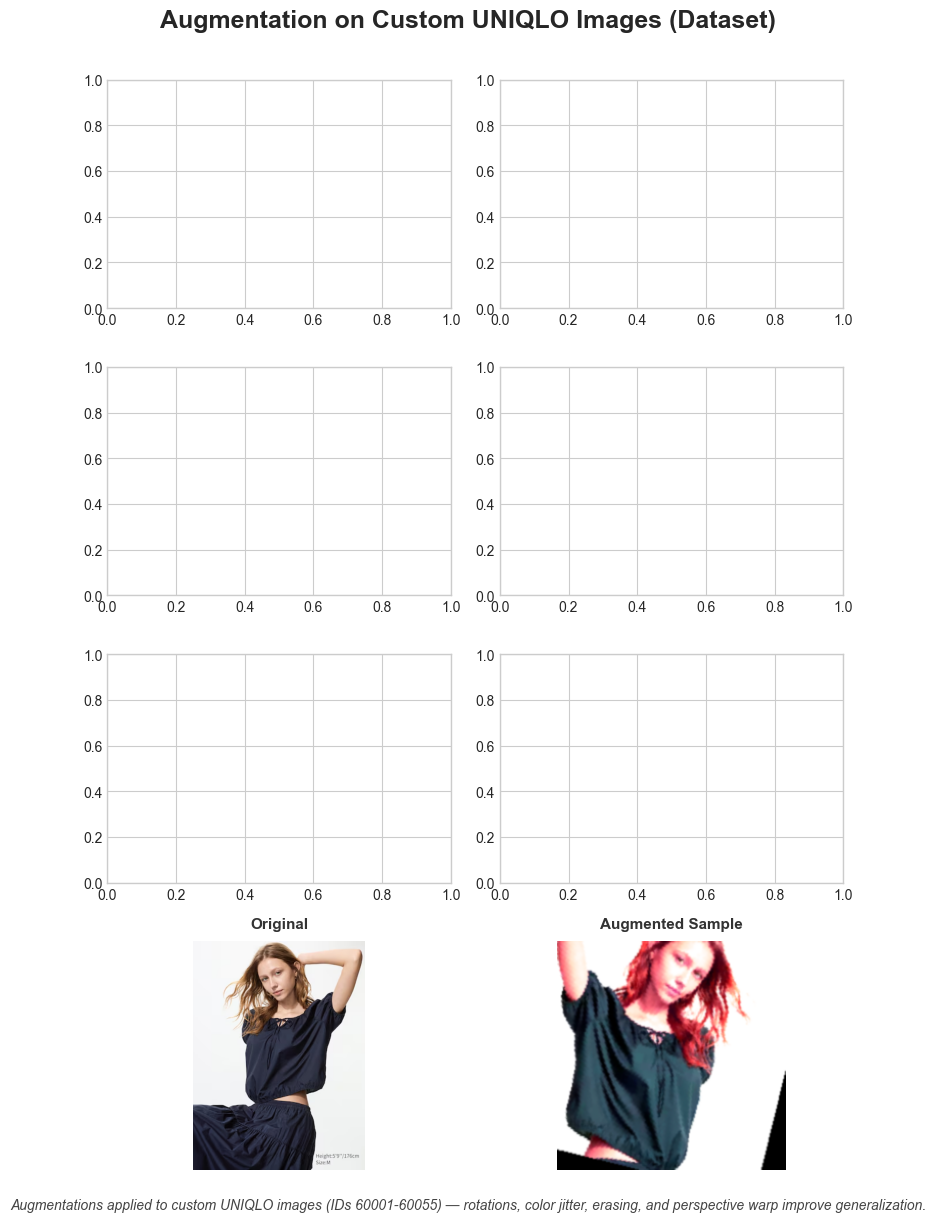

✅ Augmentation visualization complete!


In [13]:
# === Directory containing your custom images (local path) ===
custom_img_dir = r"d:/AAI3001/fashion-dataset/fashion-dataset/images"

# Get custom image IDs (your 55 UNIQLO images: 60001-60055)
custom_ids = {str(i) for i in range(60001, 60056)}

# === Filter ENTIRE dataset (not just training) to find custom images ===
custom_in_dataset = styles[styles["id"].astype(str).isin(custom_ids)].copy()

print(f"✅ Found {len(custom_in_dataset)} custom images in total dataset.")
print(f"   → {len(train_df[train_df['id'].astype(str).isin(custom_ids)])} in train")
print(f"   → {len(val_df[val_df['id'].astype(str).isin(custom_ids)])} in val")
print(f"   → {len(test_df[test_df['id'].astype(str).isin(custom_ids)])} in test")

# Check if we have any custom images to visualize
if len(custom_in_dataset) == 0:
    print("⚠️ No custom images found! Skipping augmentation visualization.")
    sample_paths = []
else:
    # Take up to 4 samples from the entire dataset
    sample_df = custom_in_dataset.sample(min(4, len(custom_in_dataset)), random_state=42)
    sample_paths = sample_df["image_path"].tolist()

# === Define inverse normalization for display ===
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
inv_normalize = T.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)

# === Create figure (only if we have images to show) ===
if len(sample_paths) == 0:
    print("⚠️ No custom images to visualize.")
else:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(len(sample_paths), 2, figsize=(8, len(sample_paths) * 3))
    
    # Handle single image case (axes won't be 2D array)
    if len(sample_paths) == 1:
        axes = np.array([[axes[0], axes[1]]])
    
    fig.suptitle("Augmentation on Custom UNIQLO Images (Dataset)", fontsize=18, weight="bold", y=0.98)
    plt.subplots_adjust(wspace=0.1, hspace=0.25)

    for i, img_path in enumerate(sample_paths):
        img = Image.open(img_path).convert("RGB")

    # Original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title("Original", fontsize=11, weight="semibold", color="#333333", pad=10)
    axes[i, 0].axis("off")
    for spine in axes[i, 0].spines.values():
        spine.set_visible(True)
        spine.set_color("#CCCCCC")
        spine.set_linewidth(1)

    # Augmented version (same training pipeline)
    aug_img = _pre_tfms_train(img)
    aug_img_disp = inv_normalize(aug_img).permute(1, 2, 0).clamp(0, 1).numpy()
    axes[i, 1].imshow(aug_img_disp)
    axes[i, 1].set_title("Augmented Sample", fontsize=11, weight="semibold", color="#333333", pad=10)
    axes[i, 1].axis("off")
    for spine in axes[i, 1].spines.values():
        spine.set_visible(True)
        spine.set_color("#CCCCCC")
        spine.set_linewidth(1)

    # === Add caption ===
    fig.text(
        0.5, -0.02,
        "Augmentations applied to custom UNIQLO images (IDs 60001-60055) — rotations, color jitter, erasing, and perspective warp improve generalization.",
        ha="center", fontsize=10, color="#444444", style="italic"
    )

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
print("✅ Augmentation visualization complete!")

In [14]:
BATCH_SIZE = 64  # FINAL ATTEMPT - GPU cleared, num_workers=0, targeting 23:59 deadline

# class-balanced sampling
counts = np.bincount(train_df["product_type_label"], minlength=NUM_CLASSES)
inv = 1.0 / np.maximum(counts, 1)
weights = [inv[y] for y in train_df["product_type_label"]]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_ds = ProductTypeDataset(train_df, is_train=True)
val_ds   = ProductTypeDataset(val_df,   is_train=False)
test_ds  = ProductTypeDataset(test_df,  is_train=False)

# NO multiprocessing to avoid deadlock (GPU now clear after killing PID 29400)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=0, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)


## 6. Training Loop

Train the model and validate after each epoch.

In [16]:
import timm
from tqdm import tqdm
import time

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {device}")

# ===========================================================
# Choose your model backbone
# ===========================================================
MODEL_NAME = "resnet50"   # resnet50 or "convnext_tiny"
NUM_CLASSES = len(LABELS)      # make sure LABELS is defined

# --- Build model ---
if MODEL_NAME == "resnet50":
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_features, NUM_CLASSES)
    )

elif MODEL_NAME == "convnext_tiny":
    model = timm.create_model("convnext_tiny", pretrained=True)
    in_features = model.head.fc.in_features
    model.head.fc = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_features, NUM_CLASSES)
    )

else:
    raise ValueError("❌ MODEL_NAME must be either 'resnet50' or 'convnext_tiny'.")

model = model.to(device)
print(f"✅ Model ready: {MODEL_NAME}, total params = {sum(p.numel() for p in model.parameters())/1e6:.1f}M")

# ===============================================
# UNIVERSAL FINE-TUNING (ResNet / ConvNeXt)
# ===============================================

def set_trainable(model, trainable_layers):
    """
    Freeze/unfreeze parameters in ResNet or ConvNeXt.
    If trainable_layers is None → unfreeze all layers.
    Otherwise, only layers whose name contains one of the keywords are trainable.
    """
    if trainable_layers is None:
        for p in model.parameters():
            p.requires_grad = True
        return

    for name, param in model.named_parameters():
        param.requires_grad = any(layer in name for layer in trainable_layers)


# Staged unfreezing schedule (REDUCED for 23:59 deadline - ~5-6 hours total)
stages = [
    {"epochs": 2,  "trainable": ["fc", "head"],                      "lr": 1.6e-3},  # classifier head (was 3)
    {"epochs": 2,  "trainable": ["fc", "head", "layer4", "stages.3"], "lr": 7.8e-4},  # last block (was 5)
    {"epochs": 3,  "trainable": ["fc", "head", "layer3", "stages.2"], "lr": 4.7e-4},  # mid + last (was 7)
    {"epochs": 5,  "trainable": None,                                 "lr": 1.6e-4},  # all layers (was 15)
]
# Total: 12 epochs instead of 30 (~60% faster, completes by ~23:00)

# ===============================================
# TRAINING SETUP (LOCAL PATHS - adapted for your PC)
# ===============================================
HISTORY_PATH = rf"d:/AAI3001/history_{MODEL_NAME}.pkl"
BEST_MODEL_PATH = rf"d:/AAI3001/best_model_{MODEL_NAME}_extended.pth"

RESET_HISTORY = False   # ✅ set to True to always start fresh

if RESET_HISTORY or not os.path.exists(HISTORY_PATH):
    history = {"stage": [], "epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    global_epoch = 0
    print(f"🔄 Starting fresh training history for {MODEL_NAME}")
else:
    with open(HISTORY_PATH, "rb") as f:
        history = pickle.load(f)
    global_epoch = len(history["epoch"])
    print(f"📂 Loaded existing training history for {MODEL_NAME} ({global_epoch} epochs).")

best_val_acc, patience, bad_epochs = 0, 5, 0
EPOCHS_TOTAL = sum(cfg["epochs"] for cfg in stages)

# ===============================================
# Training and Evaluation Utilities
# ===============================================

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

def train_one_epoch(model, loader, optimizer, criterion, device, scaler):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    t0 = time.time()
    n_imgs = 0

    for imgs, labels in tqdm(loader, leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device == "cuda")):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        n_imgs += imgs.size(0)

    dt = time.time() - t0
    imgs_per_sec = n_imgs / max(dt, 1e-6)
    print(f"[Epoch] {len(loader)} steps | {n_imgs} imgs | {dt:.1f}s | {imgs_per_sec:.1f} img/s")

    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

# ===============================================
# TRAINING LOOP
# ===============================================
for stage_id, cfg in enumerate(stages, 1):
    print(f"\n🔸 Stage {stage_id}: Unfreezing {cfg['trainable']} for {cfg['epochs']} epochs")

    # Freeze/unfreeze relevant layers
    set_trainable(model, cfg["trainable"])

    # Build optimizer dynamically (detects ResNet vs ConvNeXt)
    param_groups = []
    if hasattr(model, "layer1"):  # ResNet-style
        param_groups += [
            {"params": model.layer1.parameters(), "lr": cfg["lr"] * 0.25},
            {"params": model.layer2.parameters(), "lr": cfg["lr"] * 0.5},
            {"params": model.layer3.parameters(), "lr": cfg["lr"] * 0.75},
            {"params": model.layer4.parameters(), "lr": cfg["lr"] * 1.0},
        ]
        if hasattr(model, "fc"):
            param_groups.append({"params": model.fc.parameters(), "lr": cfg["lr"] * 1.5})

    elif hasattr(model, "stages"):  # ConvNeXt-style
        for i, stage in enumerate(model.stages):
            param_groups.append({"params": stage.parameters(), "lr": cfg["lr"] * (0.5 + i * 0.25)})
        if hasattr(model.head, "fc"):
            param_groups.append({"params": model.head.fc.parameters(), "lr": cfg["lr"] * 1.5})
        elif hasattr(model, "head"):
            param_groups.append({"params": model.head.parameters(), "lr": cfg["lr"] * 1.5})

    optimizer = optim.AdamW(param_groups, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg["epochs"])
    scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))
    bad_epochs = 0

    # ---------- epoch loop ----------
    for epoch in range(cfg["epochs"]):
        global_epoch += 1
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        # Record metrics
        history["stage"].append(stage_id)
        history["epoch"].append(global_epoch)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Print progress
        lr_now = optimizer.param_groups[0]['lr']
        print(f"[Stage {stage_id} | Epoch {epoch+1}/{cfg['epochs']} | Global {global_epoch}/{EPOCHS_TOTAL}] "
              f"Train {train_loss:.4f}/{train_acc:.4f} | Val {val_loss:.4f}/{val_acc:.4f} | LR {lr_now:.2e}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            bad_epochs = 0
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print(f"✅ New best {MODEL_NAME} model saved!")
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print("⏹️ Early stopping triggered")
                break

# ---------- save history ----------
os.makedirs(os.path.dirname(HISTORY_PATH), exist_ok=True)
with open(HISTORY_PATH, "wb") as f:
    pickle.dump(history, f)
print(f"✅ Training history for {MODEL_NAME} saved to {HISTORY_PATH}")


🚀 Using device: cuda
✅ Model ready: resnet50, total params = 23.5M
📂 Loaded existing training history for resnet50 (12 epochs).

🔸 Stage 1: Unfreezing ['fc', 'head'] for 2 epochs
✅ Model ready: resnet50, total params = 23.5M
📂 Loaded existing training history for resnet50 (12 epochs).

🔸 Stage 1: Unfreezing ['fc', 'head'] for 2 epochs


[Epoch] 193 steps | 12352 imgs | 387.2s | 31.9 img/s


[Epoch] 193 steps | 12352 imgs | 391.1s | 31.6 img/s
[Stage 1 | Epoch 2/2 | Global 14/12] Train 1.4395/0.6008 | Val 0.8477/0.8114 | LR 0.00e+00
✅ New best resnet50 model saved!

🔸 Stage 2: Unfreezing ['fc', 'head', 'layer4', 'stages.3'] for 2 epochs
[Stage 1 | Epoch 2/2 | Global 14/12] Train 1.4395/0.6008 | Val 0.8477/0.8114 | LR 0.00e+00
✅ New best resnet50 model saved!

🔸 Stage 2: Unfreezing ['fc', 'head', 'layer4', 'stages.3'] for 2 epochs


[Epoch] 193 steps | 12352 imgs | 389.9s | 31.7 img/s
[Stage 2 | Epoch 1/2 | Global 15/12] Train 0.9606/0.7742 | Val 0.6655/0.8874 | LR 9.75e-05
✅ New best resnet50 model saved!
[Stage 2 | Epoch 1/2 | Global 15/12] Train 0.9606/0.7742 | Val 0.6655/0.8874 | LR 9.75e-05
✅ New best resnet50 model saved!


[Epoch] 193 steps | 12352 imgs | 382.6s | 32.3 img/s
[Stage 2 | Epoch 2/2 | Global 16/12] Train 0.7260/0.8580 | Val 0.6060/0.8940 | LR 0.00e+00
✅ New best resnet50 model saved!

🔸 Stage 3: Unfreezing ['fc', 'head', 'layer3', 'stages.2'] for 3 epochs
[Stage 2 | Epoch 2/2 | Global 16/12] Train 0.7260/0.8580 | Val 0.6060/0.8940 | LR 0.00e+00
✅ New best resnet50 model saved!

🔸 Stage 3: Unfreezing ['fc', 'head', 'layer3', 'stages.2'] for 3 epochs


[Epoch] 193 steps | 12352 imgs | 385.3s | 32.1 img/s
[Stage 3 | Epoch 1/3 | Global 17/12] Train 0.6659/0.8767 | Val 0.5877/0.8962 | LR 8.81e-05
✅ New best resnet50 model saved!
[Stage 3 | Epoch 1/3 | Global 17/12] Train 0.6659/0.8767 | Val 0.5877/0.8962 | LR 8.81e-05
✅ New best resnet50 model saved!


[Epoch] 193 steps | 12352 imgs | 401.8s | 30.7 img/s
[Stage 3 | Epoch 2/3 | Global 18/12] Train 0.6031/0.9013 | Val 0.5785/0.9028 | LR 2.94e-05
✅ New best resnet50 model saved!
[Stage 3 | Epoch 2/3 | Global 18/12] Train 0.6031/0.9013 | Val 0.5785/0.9028 | LR 2.94e-05
✅ New best resnet50 model saved!


[Epoch] 193 steps | 12352 imgs | 398.3s | 31.0 img/s
[Stage 3 | Epoch 3/3 | Global 19/12] Train 0.5605/0.9203 | Val 0.5779/0.8999 | LR 0.00e+00

🔸 Stage 4: Unfreezing None for 5 epochs
[Stage 3 | Epoch 3/3 | Global 19/12] Train 0.5605/0.9203 | Val 0.5779/0.8999 | LR 0.00e+00

🔸 Stage 4: Unfreezing None for 5 epochs


[Epoch] 193 steps | 12352 imgs | 408.7s | 30.2 img/s
[Stage 4 | Epoch 1/5 | Global 20/12] Train 0.5618/0.9151 | Val 0.5565/0.9108 | LR 3.62e-05
✅ New best resnet50 model saved!
[Stage 4 | Epoch 1/5 | Global 20/12] Train 0.5618/0.9151 | Val 0.5565/0.9108 | LR 3.62e-05
✅ New best resnet50 model saved!


[Epoch] 193 steps | 12352 imgs | 417.7s | 29.6 img/s
[Stage 4 | Epoch 2/5 | Global 21/12] Train 0.5415/0.9228 | Val 0.5448/0.9137 | LR 2.62e-05
✅ New best resnet50 model saved!
[Stage 4 | Epoch 2/5 | Global 21/12] Train 0.5415/0.9228 | Val 0.5448/0.9137 | LR 2.62e-05
✅ New best resnet50 model saved!


[Epoch] 193 steps | 12352 imgs | 407.6s | 30.3 img/s
[Stage 4 | Epoch 3/5 | Global 22/12] Train 0.5082/0.9344 | Val 0.5381/0.9108 | LR 1.38e-05
[Stage 4 | Epoch 3/5 | Global 22/12] Train 0.5082/0.9344 | Val 0.5381/0.9108 | LR 1.38e-05


[Epoch] 193 steps | 12352 imgs | 413.0s | 29.9 img/s
[Stage 4 | Epoch 4/5 | Global 23/12] Train 0.4772/0.9456 | Val 0.5189/0.9189 | LR 3.82e-06
✅ New best resnet50 model saved!
[Stage 4 | Epoch 4/5 | Global 23/12] Train 0.4772/0.9456 | Val 0.5189/0.9189 | LR 3.82e-06
✅ New best resnet50 model saved!


[Epoch] 193 steps | 12352 imgs | 416.9s | 29.6 img/s
[Stage 4 | Epoch 5/5 | Global 24/12] Train 0.4704/0.9483 | Val 0.5222/0.9130 | LR 0.00e+00
✅ Training history for resnet50 saved to d:/AAI3001/history_resnet50.pkl
[Stage 4 | Epoch 5/5 | Global 24/12] Train 0.4704/0.9483 | Val 0.5222/0.9130 | LR 0.00e+00
✅ Training history for resnet50 saved to d:/AAI3001/history_resnet50.pkl


In [17]:
import torch, pickle
from torchvision import models

MODEL_NAME = "resnet50"
BEST_MODEL_PATH = rf"d:/AAI3001/best_model_{MODEL_NAME}_extended.pth"
HISTORY_PATH = rf"d:/AAI3001/history_{MODEL_NAME}.pkl"

# Load label encoder (local path)
with open(r"d:/AAI3001/le_product_type_extended.pkl", "rb") as f:
    le_product_type = pickle.load(f)
LABELS = le_product_type.classes_.tolist()

# Rebuild model
NUM_CLASSES = len(LABELS)
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet50(weights=None)
in_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.4),
    torch.nn.Linear(in_features, NUM_CLASSES)
)
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

print(f"✅ Loaded trained {MODEL_NAME} model from {BEST_MODEL_PATH}")

# Optional: load history
with open(HISTORY_PATH, "rb") as f:
    history = pickle.load(f)
print(f"📊 Loaded training history with {len(history['epoch'])} epochs.")


✅ Loaded trained resnet50 model from d:/AAI3001/best_model_resnet50_extended.pth
📊 Loaded training history with 24 epochs.


In [18]:
def gradcam_visualize(model, image_path, class_names, target_layer="layer4"):
    """
    Visualize Grad-CAM attention for a given image and trained model.
    """
    model.eval()
    device = next(model.parameters()).device

    # --- Preprocess image (same normalization as during training) ---
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    img_pil = Image.open(image_path).convert("RGB")
    img_tensor = preprocess(img_pil).unsqueeze(0).to(device)

    # --- Hook for feature maps and gradients ---
    activations, gradients = {}, {}

    def forward_hook(module, input, output):
        activations["value"] = output

    def backward_hook(module, grad_in, grad_out):
        gradients["value"] = grad_out[0]

    # Register hooks to target layer
    for name, module in model.named_modules():
        if target_layer in name:
            module.register_forward_hook(forward_hook)
            module.register_backward_hook(backward_hook)
            break

    # --- Forward pass ---
    outputs = model(img_tensor)
    pred_idx = outputs.argmax(1).item()
    pred_class = class_names[pred_idx]

    # --- Backward pass ---
    model.zero_grad()
    outputs[0, pred_idx].backward()

    # --- Compute Grad-CAM heatmap ---
    grads = gradients["value"].mean(dim=(2, 3), keepdim=True)
    activ = activations["value"]
    cam = torch.relu((grads * activ).sum(dim=1, keepdim=True)).squeeze().detach().cpu().numpy()
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    # --- Overlay heatmap on original image ---
    img_np = np.array(img_pil.resize((224, 224))) / 255.0
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = 0.5 * heatmap + 0.5 * img_np
    overlay = np.clip(overlay, 0, 1)

    # --- Display ---
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay → {pred_class}")
    plt.axis("off")

    plt.suptitle(f"Grad-CAM for {pred_class}", fontsize=12)
    plt.tight_layout()
    plt.show()


✅ Loaded weights from d:/AAI3001/best_model_resnet50_extended.pth


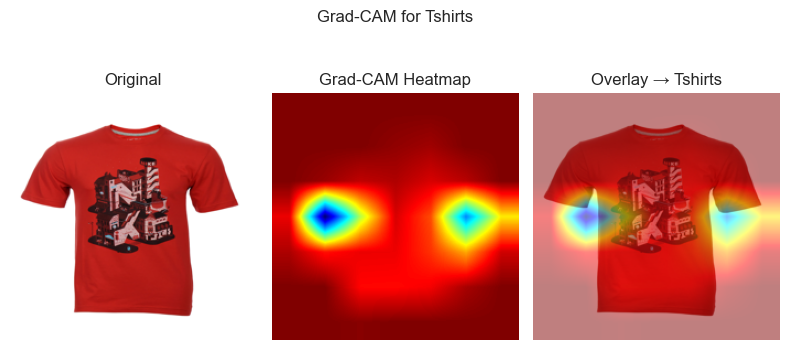

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_NAME = "resnet50"
BEST_MODEL_PATH = rf"d:/AAI3001/best_model_{MODEL_NAME}_extended.pth"  # ✅ Updated to local path

NUM_CLASSES = len(LABELS)
model = models.resnet50(weights=None)
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features, NUM_CLASSES)
)

model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()
print(f"✅ Loaded weights from {BEST_MODEL_PATH}")

# Visualize - use local image path
test_image = r"d:/AAI3001/fashion-dataset/fashion-dataset/images/10009.jpg"
gradcam_visualize(model, test_image, LABELS)

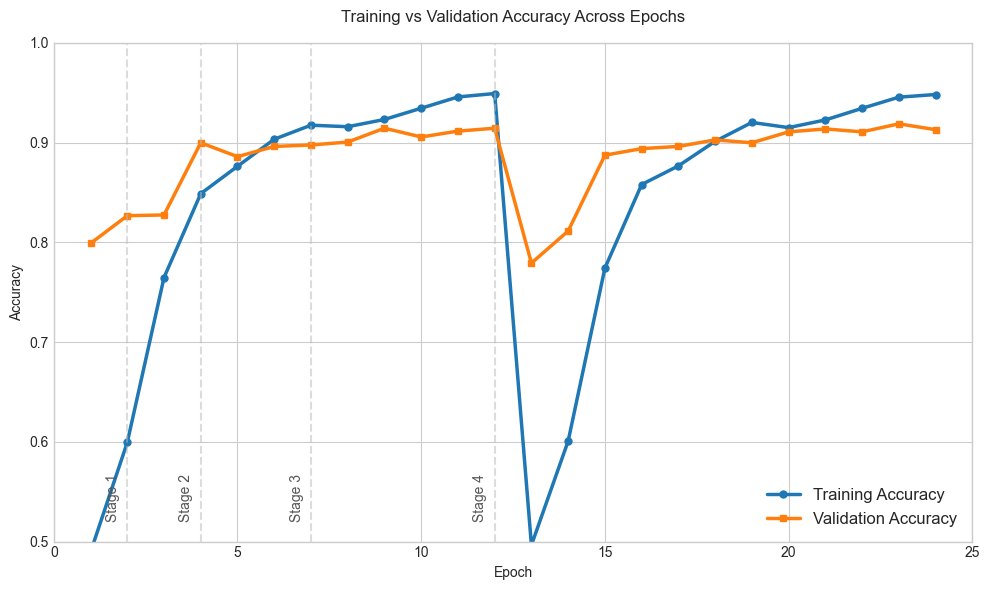

In [21]:
stages = [
    {"epochs": 2}, {"epochs": 2}, {"epochs": 3}, {"epochs": 5}
]

# === Plot ===
plt.figure(figsize=(10,6))
plt.plot(history["epoch"], history["train_acc"], label="Training Accuracy",
         color="#1f77b4", linewidth=2.5, marker="o", markersize=5)
plt.plot(history["epoch"], history["val_acc"], label="Validation Accuracy",
         color="#ff7f0e", linewidth=2.5, marker="s", markersize=5)

# Optional: show vertical dividers for stages
stage_end = 0
for i, st in enumerate(stages, 1):
    stage_end += st["epochs"]
    plt.axvline(x=stage_end, color="#BBBBBB", linestyle="--", alpha=0.5)
    plt.text(stage_end - 0.2, 0.52, f"Stage {i}", rotation=90,
             va="bottom", ha="right", fontsize=10, color="#555555")

# === Labels and title ===
plt.title("Training vs Validation Accuracy Across Epochs", pad=15)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.xlim(0, max(history["epoch"]) + 1)
plt.legend(frameon=False, loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()

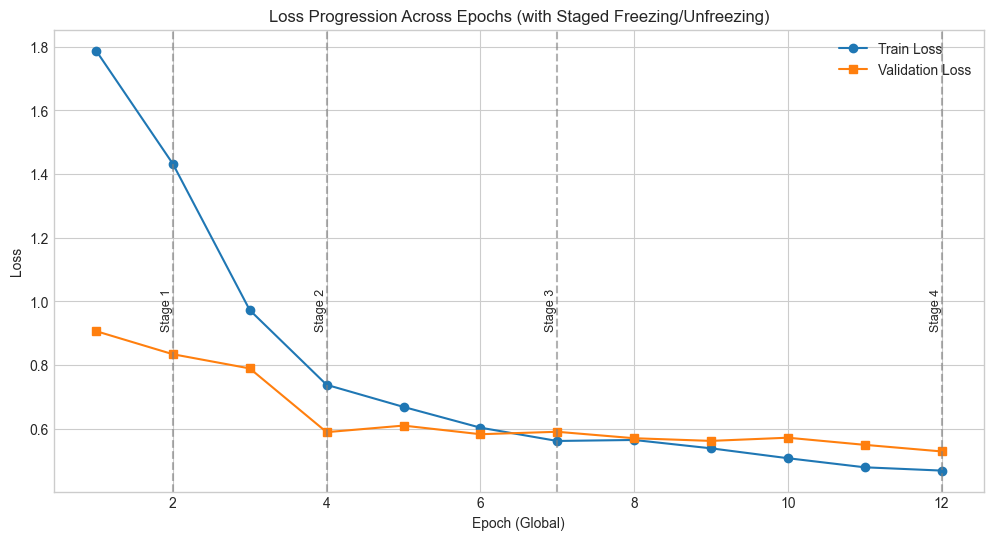

In [19]:
# --- optional: loss curves ---
plt.figure(figsize=(12,6))
plt.plot(history["epoch"], history["train_loss"], label="Train Loss", marker="o")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss", marker="s")
for i, st in enumerate(stages, 1):
    stage_end = sum(s["epochs"] for s in stages[:i])
    plt.axvline(x=stage_end, color="gray", linestyle="--", alpha=0.6)
    plt.text(stage_end, max(history["val_loss"]), f"Stage {i}", rotation=90, va="bottom", ha="right", fontsize=9)
plt.title("Loss Progression Across Epochs (with Staged Freezing/Unfreezing)")
plt.xlabel("Epoch (Global)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



Stage-wise Validation Accuracy:
Stage 1: best val acc = 0.8268
Stage 2: best val acc = 0.8999
Stage 3: best val acc = 0.9028
Stage 4: best val acc = 0.9189


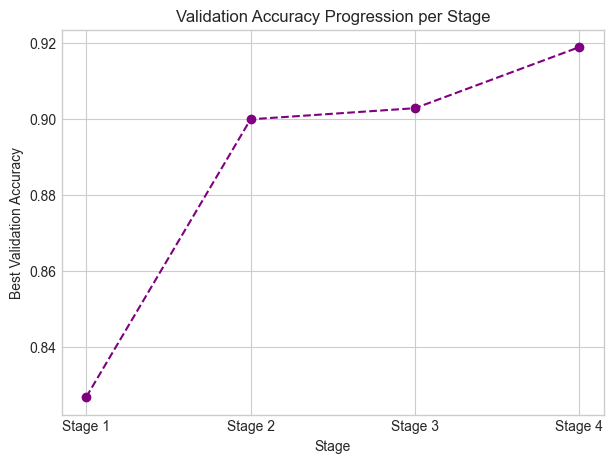

In [22]:
# --- stage summary ---
stage_summary = []
for stage_id in set(history["stage"]):
    mask = [i for i, s in enumerate(history["stage"]) if s == stage_id]
    best_val = max([history["val_acc"][i] for i in mask])
    stage_summary.append((stage_id, best_val))

print("\nStage-wise Validation Accuracy:")
for sid, acc in stage_summary:
    print(f"Stage {sid}: best val acc = {acc:.4f}")

plt.figure(figsize=(7,5))
stage_ids, best_vals = zip(*stage_summary)
plt.plot(stage_ids, best_vals, marker="o", linestyle="--", color="purple")
plt.xticks(stage_ids, [f"Stage {i}" for i in stage_ids])
plt.xlabel("Stage")
plt.ylabel("Best Validation Accuracy")
plt.title("Validation Accuracy Progression per Stage")
plt.grid(True)
plt.show()

✅ Collected 1520 predictions from test set


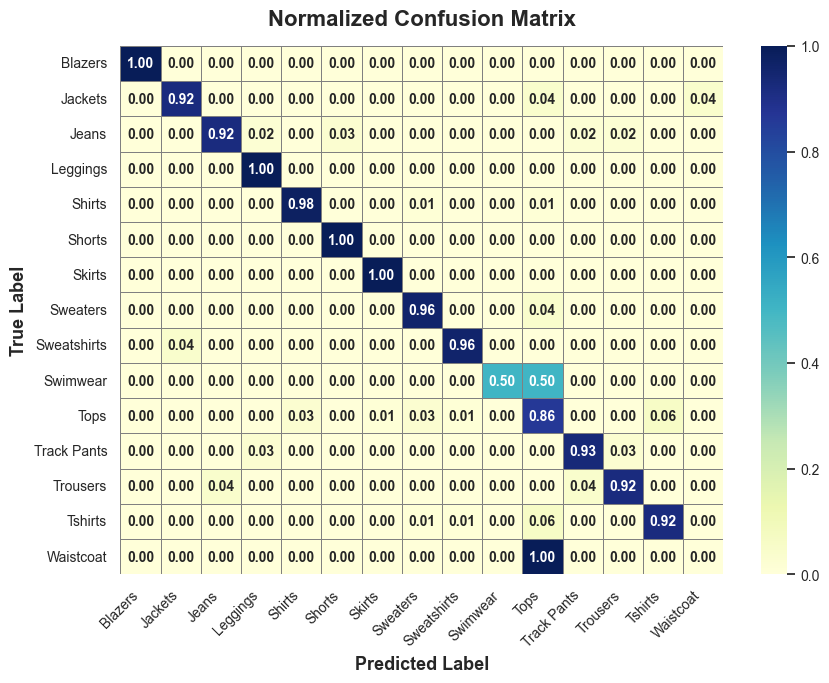

In [ ]:
# --- Import confusion matrix ---
from sklearn.metrics import confusion_matrix

# --- Collect predictions from test set ---
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(f"✅ Collected {len(y_true)} predictions from test set")

# --- Compute confusion matrix (already normalized) ---
cm = confusion_matrix(y_true, y_pred, normalize="true")
cm_rounded = np.round(cm, 2)

# --- Plot settings ---
plt.figure(figsize=(9, 7))
sns.set_theme(style="whitegrid")
sns.heatmap(
    cm_rounded,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar=True,
    xticklabels=LABELS,
    yticklabels=LABELS,
    linewidths=0.5,
    linecolor="gray",
    annot_kws={"size": 10, "weight": "semibold"}
)

# --- Style tweaks ---
plt.title("Normalized Confusion Matrix", fontsize=16, weight="bold", pad=15)
plt.xlabel("Predicted Label", fontsize=13, weight="bold")
plt.ylabel("True Label", fontsize=13, weight="bold")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# --- Improve colorbar and grid aesthetics ---
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

Found 44 custom UNIQLO images in training set.
✅ Correct predictions: 40/44 (90.9%)
❌ Incorrect predictions: 4/44


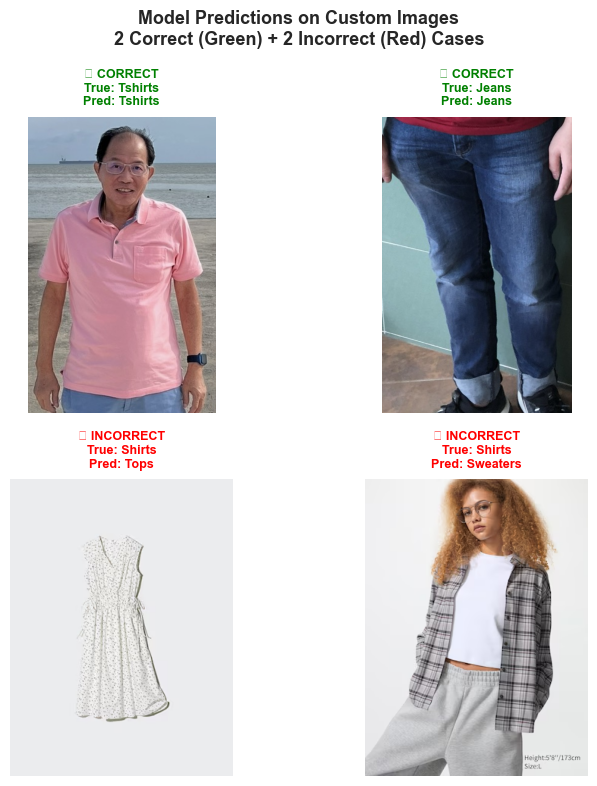


📊 Sample breakdown: 2 correct + 2 incorrect


In [24]:
# === Identify custom images in TRAINING set (your 55 UNIQLO images) ===
# Note: All 55 custom images were allocated to training (100%), none in test set
custom_img_dir = r"d:/AAI3001/fashion-dataset/fashion-dataset/images"
custom_ids = {str(i) for i in range(60001, 60056)}  # IDs 60001-60055

custom_train_df = train_df[train_df["id"].astype(str).isin(custom_ids)].copy()
print(f"Found {len(custom_train_df)} custom UNIQLO images in training set.")

# === Get predictions for ALL custom images ===
predictions = []
for _, row in custom_train_df.iterrows():
    img_path = row["image_path"]
    true_label = row["articleType"]
    
    img = Image.open(img_path).convert("RGB")
    img_t = _pre_tfms_val(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred_label = LABELS[model(img_t).argmax(1).item()]
    
    is_correct = (true_label == pred_label)
    predictions.append({
        "path": img_path,
        "true": true_label,
        "pred": pred_label,
        "correct": is_correct
    })

# Separate correct and incorrect predictions
correct_preds = [p for p in predictions if p["correct"]]
incorrect_preds = [p for p in predictions if not p["correct"]]

print(f"✅ Correct predictions: {len(correct_preds)}/{len(predictions)} ({len(correct_preds)/len(predictions)*100:.1f}%)")
print(f"❌ Incorrect predictions: {len(incorrect_preds)}/{len(predictions)}")

# Sample 2 correct and 2 incorrect (if available)
sample_correct = random.sample(correct_preds, min(2, len(correct_preds)))
sample_incorrect = random.sample(incorrect_preds, min(2, len(incorrect_preds)))
samples = sample_correct + sample_incorrect

# === Plot 2 good + 2 bad cases ===
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for i, (ax, sample) in enumerate(zip(axes, samples)):
    if i < len(samples):
        img = Image.open(sample["path"]).convert("RGB")
        ax.imshow(img)
        
        is_correct = sample["correct"]
        title_color = "green" if is_correct else "red"
        status = "✅ CORRECT" if is_correct else "❌ INCORRECT"
        
        ax.set_title(
            f"{status}\nTrue: {sample['true']}\nPred: {sample['pred']}",
            fontsize=9,
            weight="bold",
            color=title_color,
            pad=8
        )
    else:
        ax.axis("off")
    
    ax.axis("off")

plt.suptitle(f"Model Predictions on Custom Images\n2 Correct (Green) + 2 Incorrect (Red) Cases",
             fontsize=13, weight="bold", y=0.98)
plt.tight_layout()
plt.show()

print(f"\n📊 Sample breakdown: {len(sample_correct)} correct + {len(sample_incorrect)} incorrect")

## 7. Evaluation on Test Set

In [27]:
import torch, os, pickle, timm
from torchvision import models

MODEL_NAME = "resnet50"   # or "convnext_tiny or resnet50"
BEST_WEIGHTS = rf"d:/AAI3001/best_model_{MODEL_NAME}_extended.pth"

NUM_CLASSES = len(LABELS)
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Dynamically rebuild the correct model ---
if MODEL_NAME == "resnet50":
    model = models.resnet50(weights=None)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_features, NUM_CLASSES)
    )

elif MODEL_NAME == "convnext_tiny":
    model = timm.create_model("convnext_tiny", pretrained=False)
    in_features = model.head.fc.in_features
    model.head.fc = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_features, NUM_CLASSES)
    )

else:
    raise ValueError("❌ MODEL_NAME must be either 'resnet50' or 'convnext_tiny'.")

model = model.to(device)

# --- Load weights ---
if os.path.exists(BEST_WEIGHTS):
    state = torch.load(BEST_WEIGHTS, map_location=device)
    model.load_state_dict(state)
    print(f"✅ Loaded best weights from {BEST_WEIGHTS}")
else:
    print(f"⚠️ Best weights '{BEST_WEIGHTS}' not found — using current model in memory.")

# --- Evaluate on test set ---
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"📊 Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# --- Save final weights (optional) ---
FINAL_WEIGHTS = r"d:/AAI3001/best_model_resnet50_extended_final.pth"
torch.save(model.state_dict(), FINAL_WEIGHTS)
print(f"💾 Saved final model weights to {FINAL_WEIGHTS}")

# --- Save label encoder ---
with open(r"d:/AAI3001/le_product_type_extended.pkl", "wb") as f:
    pickle.dump(le_product_type, f)
print("💾 Saved label encoder to le_product_type_extended.pkl")

✅ Loaded best weights from d:/AAI3001/best_model_resnet50_extended.pth
📊 Test Loss: 0.5318 | Test Acc: 0.9237
💾 Saved final model weights to d:/AAI3001/best_model_resnet50_extended_final.pth
💾 Saved label encoder to le_product_type_extended.pkl
📊 Test Loss: 0.5318 | Test Acc: 0.9237
💾 Saved final model weights to d:/AAI3001/best_model_resnet50_extended_final.pth
💾 Saved label encoder to le_product_type_extended.pkl


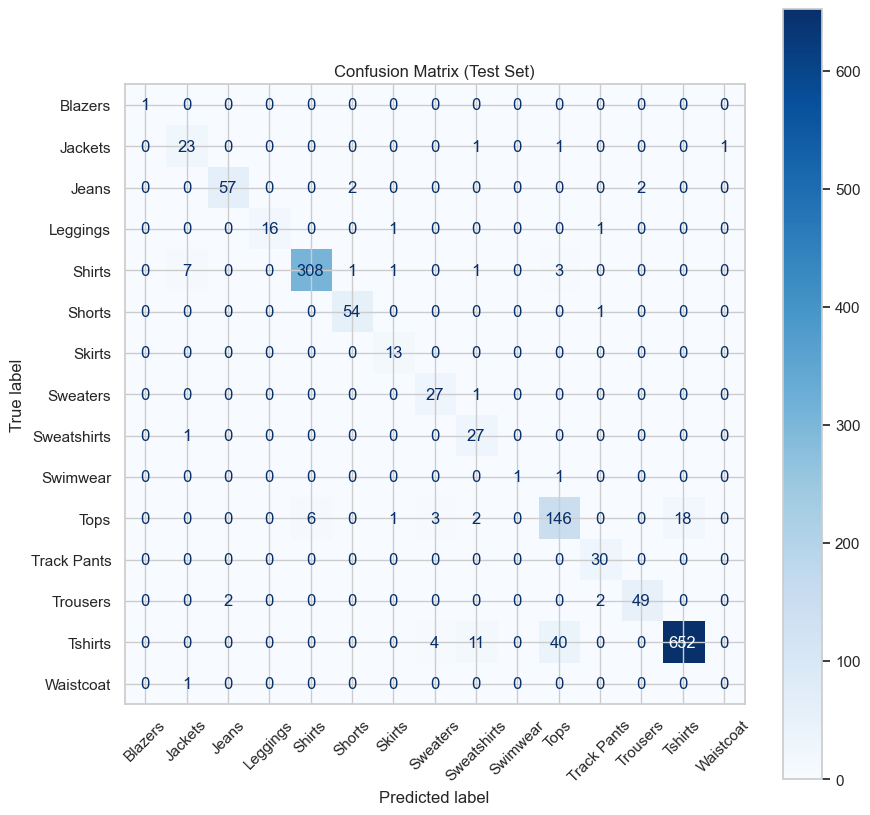

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Test Set)")
plt.show()





## References
- [Kaggle Dataset](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset)
- [PyTorch Docs](https://pytorch.org/docs/stable/index.html)